In [103]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.cluster import MiniBatchKMeans, KMeans
import setGPU
import numpy as np
import h5py

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import setGPU

sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import sys,os
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('IDEC/')))
import idec_graph as idec_mod
reload(idec_mod)
from idec_graph import IDEC
import IDEC.utils as utils_idec
reload(utils_idec)
from scipy.sparse import csr_matrix

from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from IDEC.utils import GraphDataset, cluster_acc
from torch_scatter import scatter_mean,scatter_max

from sklearn.manifold import TSNE

import matplotlib.colors as colors


In [3]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/inputs/'
TRAIN_NAME = 'background_chan3_passed_ae_l1.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['dataset'])
file_dataset[:,:,2] = file_dataset[:,:,2]/1e5
file_dataset[:,:,3] = file_dataset[:,:,3]/1e5

n_proc = 3
(unique, counts) = np.unique(file_dataset[:,:,0], return_counts=True)
procs_sorted, counts_sorted = zip(*sorted(zip(unique, counts), key=lambda x: x[1],reverse=True))
top_proc_mask = np.isin(file_dataset[:,0,0], procs_sorted[:n_proc]) #choose top 3
file_dataset = file_dataset[top_proc_mask]

datas = []
tot_evt =  file_dataset.shape[0]# int(1e4)
print('Preparing the dataset of {} events'.format(tot_evt))
n_objs = 17
adj = [csr_matrix(np.ones((n_objs,n_objs)) - np.eye(n_objs))]*tot_evt
edge_index = [from_scipy_sparse_matrix(a)[0] for a in adj]      
x = [torch.tensor(file_dataset[i_evt,:,1:], dtype=torch.float) for i_evt in range(tot_evt)]
y = [torch.tensor(int(file_dataset[i_evt,0,0]), dtype=torch.int) for i_evt in range(tot_evt)]
datas = [Data(x=x_jet, edge_index=edge_index_jet,y=torch.unsqueeze(u_jet, 0)) 
    for x_jet,edge_index_jet,u_jet in zip(x,edge_index,y)]
print('Dataset of {} events prepared'.format(tot_evt))
dataset  = GraphDataset(datas)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Preparing the dataset of 62305 events
Dataset of 62305 events prepared


In [104]:
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


num_clusters_dict = {}

for num_cluster in [3]:  
    model = IDEC(input_shape = [17,5], 
                hidden_channels = [4,4,3,3,2,2],
                latent_dim =10,
                n_clusters=num_cluster,
                alpha=1,
                pretrain_path='data_graph/graph_ae_pretrain.pkl'
    ).to(device)

    model.load_state_dict(torch.load(
"/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/IDEC/data_graph/graph_ae_pretrain_top_3_fullmodel_num_clust_{}.pkl".format(num_cluster)))

    batch_size=256
    test_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    latent_pred = []
    true_labels = []
    model.eval() 
    
    pred_features = np.array([model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
        
    acc, nmi, ari,reassignment, true_labels, pred_labels, latent_pred  = model.validateOnCompleteTestData(test_loader)

    print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
    predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
    idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
    num_clusters_dict[num_cluster] = {}
    num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])

    

RuntimeError: Error(s) in loading state_dict for IDEC:
	size mismatch for ae.enc_convs.0.edgeconv.nn.0.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([4, 10]).
	size mismatch for ae.enc_convs.0.edgeconv.nn.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.0.edgeconv.nn.1.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.0.edgeconv.nn.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.0.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.0.edgeconv.nn.1.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.1.edgeconv.nn.0.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for ae.enc_convs.1.edgeconv.nn.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.1.edgeconv.nn.1.weight: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.1.edgeconv.nn.1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.1.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.1.edgeconv.nn.1.running_var: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.enc_convs.2.edgeconv.nn.0.weight: copying a param with shape torch.Size([30, 40]) from checkpoint, the shape in current model is torch.Size([3, 8]).
	size mismatch for ae.enc_convs.2.edgeconv.nn.0.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.2.edgeconv.nn.1.weight: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.2.edgeconv.nn.1.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.2.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.2.edgeconv.nn.1.running_var: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.3.edgeconv.nn.0.weight: copying a param with shape torch.Size([20, 60]) from checkpoint, the shape in current model is torch.Size([3, 6]).
	size mismatch for ae.enc_convs.3.edgeconv.nn.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.3.edgeconv.nn.1.weight: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.3.edgeconv.nn.1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.3.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.3.edgeconv.nn.1.running_var: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.enc_convs.4.edgeconv.nn.0.weight: copying a param with shape torch.Size([10, 40]) from checkpoint, the shape in current model is torch.Size([2, 6]).
	size mismatch for ae.enc_convs.4.edgeconv.nn.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.enc_convs.4.edgeconv.nn.1.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.enc_convs.4.edgeconv.nn.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.enc_convs.4.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.enc_convs.4.edgeconv.nn.1.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.enc_convs.5.edgeconv.nn.0.weight: copying a param with shape torch.Size([2, 20]) from checkpoint, the shape in current model is torch.Size([2, 4]).
	size mismatch for ae.dec_convs.1.edgeconv.nn.0.weight: copying a param with shape torch.Size([10, 4]) from checkpoint, the shape in current model is torch.Size([2, 4]).
	size mismatch for ae.dec_convs.1.edgeconv.nn.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.dec_convs.1.edgeconv.nn.1.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.dec_convs.1.edgeconv.nn.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.dec_convs.1.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.dec_convs.1.edgeconv.nn.1.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for ae.dec_convs.2.edgeconv.nn.0.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([3, 4]).
	size mismatch for ae.dec_convs.2.edgeconv.nn.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.2.edgeconv.nn.1.weight: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.2.edgeconv.nn.1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.2.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.2.edgeconv.nn.1.running_var: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.3.edgeconv.nn.0.weight: copying a param with shape torch.Size([30, 40]) from checkpoint, the shape in current model is torch.Size([3, 6]).
	size mismatch for ae.dec_convs.3.edgeconv.nn.0.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.3.edgeconv.nn.1.weight: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.3.edgeconv.nn.1.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.3.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.3.edgeconv.nn.1.running_var: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for ae.dec_convs.4.edgeconv.nn.0.weight: copying a param with shape torch.Size([20, 60]) from checkpoint, the shape in current model is torch.Size([4, 6]).
	size mismatch for ae.dec_convs.4.edgeconv.nn.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.4.edgeconv.nn.1.weight: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.4.edgeconv.nn.1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.4.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.4.edgeconv.nn.1.running_var: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.5.edgeconv.nn.0.weight: copying a param with shape torch.Size([10, 40]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for ae.dec_convs.5.edgeconv.nn.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.5.edgeconv.nn.1.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.5.edgeconv.nn.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.5.edgeconv.nn.1.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.5.edgeconv.nn.1.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ae.dec_convs.6.edgeconv.nn.0.weight: copying a param with shape torch.Size([5, 20]) from checkpoint, the shape in current model is torch.Size([5, 8]).

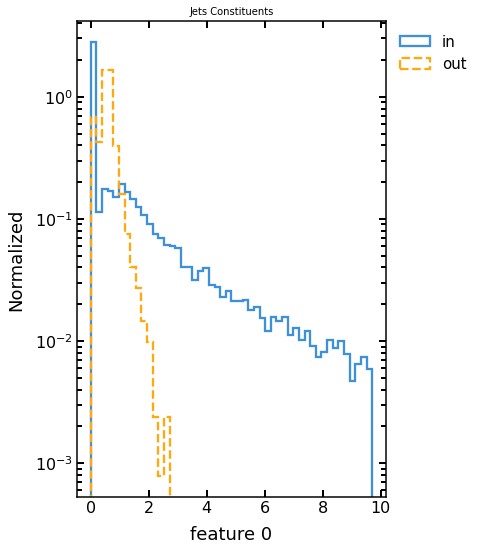

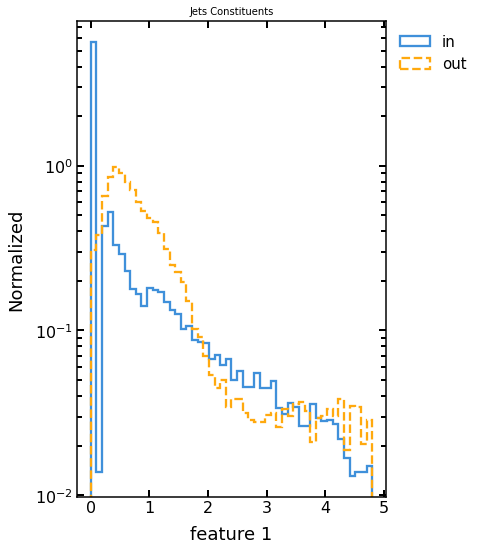

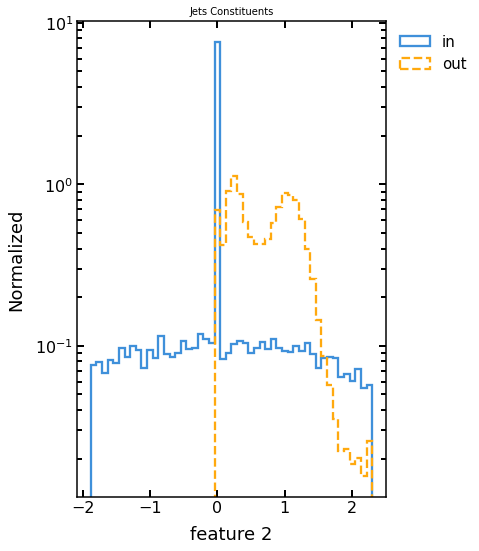

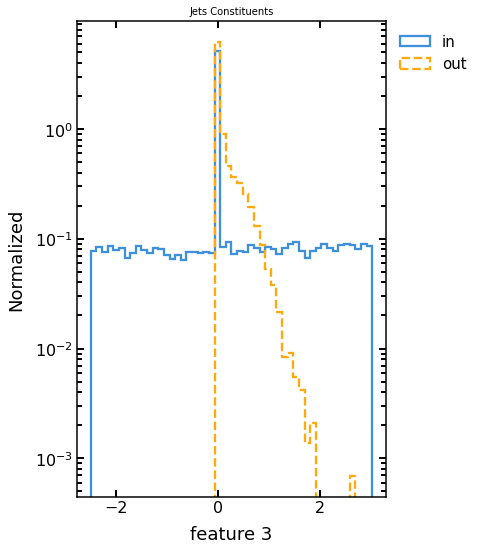

In [98]:
sys.path.append(os.path.abspath(os.path.join('../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)

t = file_dataset[:int(1e3),:,2:]
t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

pred_features = np.array([model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
pred_features_small = pred_features[:3]
pred_features_2 = pred_features_small.reshape((pred_features_small.shape[0])*pred_features_small.shape[1],pred_features_small.shape[2])



vande_plot.plot_features([t,pred_features_2], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    


In [99]:
X_embedded = TSNE(n_components=2,verbose=1, perplexity=20, n_iter=1000, learning_rate=200
                 ).fit_transform(latent_pred[idx])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.008s...
[t-SNE] Computed neighbors for 3000 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 126.750122
[t-SNE] KL divergence after 800 iterations: 3.030306


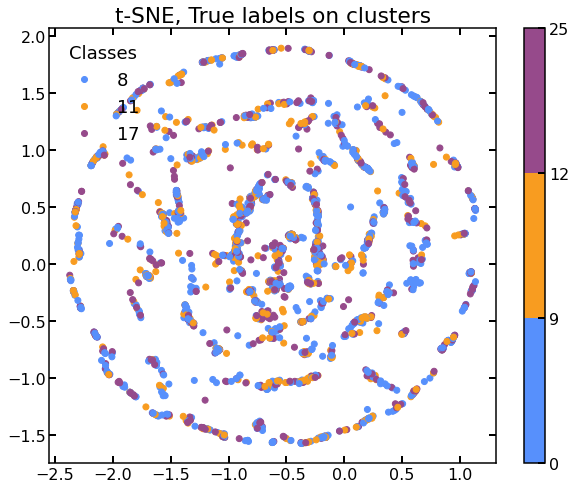

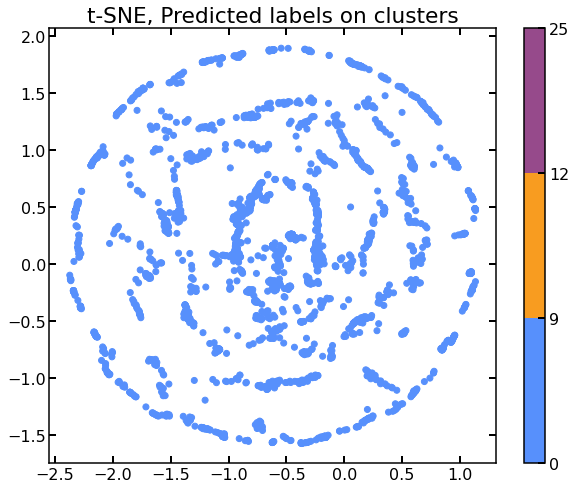

In [100]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


cmap = plt.cm.rainbow #rainbow
cmap = (colors.ListedColormap(['#5790fc', '#f89c20', '#e42536', '#964a8b'])
        .with_extremes(over='0.25', under='0.75'))
#norm = colors.BoundaryNorm(np.arange(1, 26, 1), cmap.N)
norm = colors.BoundaryNorm([0,9,12,25], cmap.N)

fig = plt.figure(figsize=(10,8))

#top_proc_mask = np.isin(true_labels[idx], result1[:5])
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1], c=true_labels[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, True labels on clusters')
cb = plt.colorbar()
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")

#ax.add_artist(legend1)


fig = plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=np.array(predicted_reassigned)[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, Predicted labels on clusters')
cb = plt.colorbar()

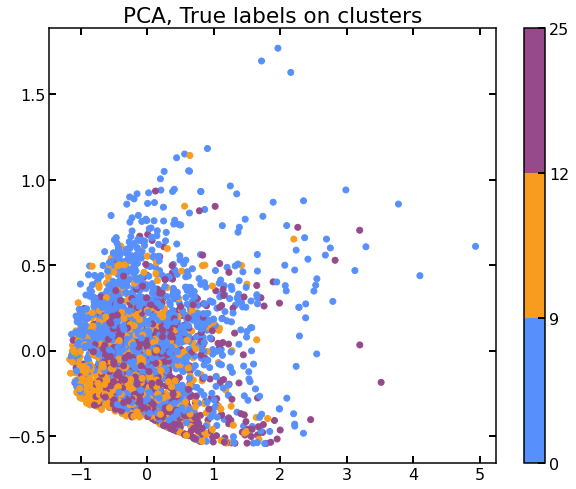

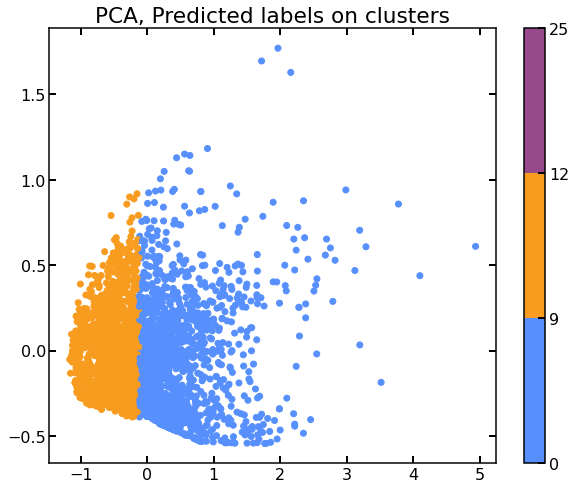

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import colors


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(latent_pred))

pc1 = principalComponents[:,0][idx]
pc2 = principalComponents[:,1][idx]




fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=true_labels[idx],cmap=cmap, norm=norm, marker='o')
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()



fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=predicted_reassigned[idx],cmap=cmap, norm=norm)
plt.title('PCA, Predicted labels on clusters')
cb = plt.colorbar()



In [83]:
np.unique(predicted_reassigned)

array([ 8, 11])

In [92]:
np.max(file_dataset[:,1,3])

34.1036